In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [2]:
folder = 'photo'
file = 'download.csv'

In [3]:
path = Path('data')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [4]:
download_images(path/file, dest)

Error https://gb.fotolibra.com/images/larger-thumbnails/105084-stained-glass-st-vitus-cathedral-prague.jpeg HTTPSConnectionPool(host='gb.fotolibra.com', port=443): Max retries exceeded with url: /images/larger-thumbnails/105084-stained-glass-st-vitus-cathedral-prague.jpeg (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])")))
Error https://gb.fotolibra.com/images/larger-thumbnails/182830-stained-glass-window-in-st-vitus-cathedr.jpeg HTTPSConnectionPool(host='gb.fotolibra.com', port=443): Max retries exceeded with url: /images/larger-thumbnails/182830-stained-glass-window-in-st-vitus-cathedr.jpeg (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])")))
Error https://gb.fotolibra.com/images/previews/182828-stained-glass-window-in-st-vitus-cathedral-prague.jpeg HTTPSConnectionPool(host='gb.fotolibra.com', port=443): Max retries

In [5]:
verify_images(path/folder, delete=True)

cannot identify image file <_io.BufferedReader name='data/photo/00000145.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000547.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000505.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000506.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000445.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000483.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000129.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000155.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000367.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000118.jpg'>
cannot identify image file <_io.BufferedReader name='data/photo/00000491.jpg'>


In [5]:
path_hr = path/'photo'
path_lr = path/'crappy'

In [8]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        fnt0 = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 30)
        fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 10)
        ImageDraw.Draw(img).text((random.randint(0,w//6),random.randint(0,h//6)), str("00:28"), fill=(255,255,255), font=fnt0)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str("CMHK"), fill=(255,255,255), font=fnt)
        ImageDraw.Draw(img).text((random.randint(w//2, w),random.randint(0,h//2)), str("99%"), fill=(255,255,255), font=fnt)
        ImageDraw.Draw(img).rectangle((70, 5, 90, 10), fill=(255,209,0))
        #img.save(dest, quality=q)
        img.save(dest)

In [9]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

In [6]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

In [7]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [8]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(resize_method=ResizeMethod.SQUISH, size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [9]:
data_gen = get_data(bs,size)

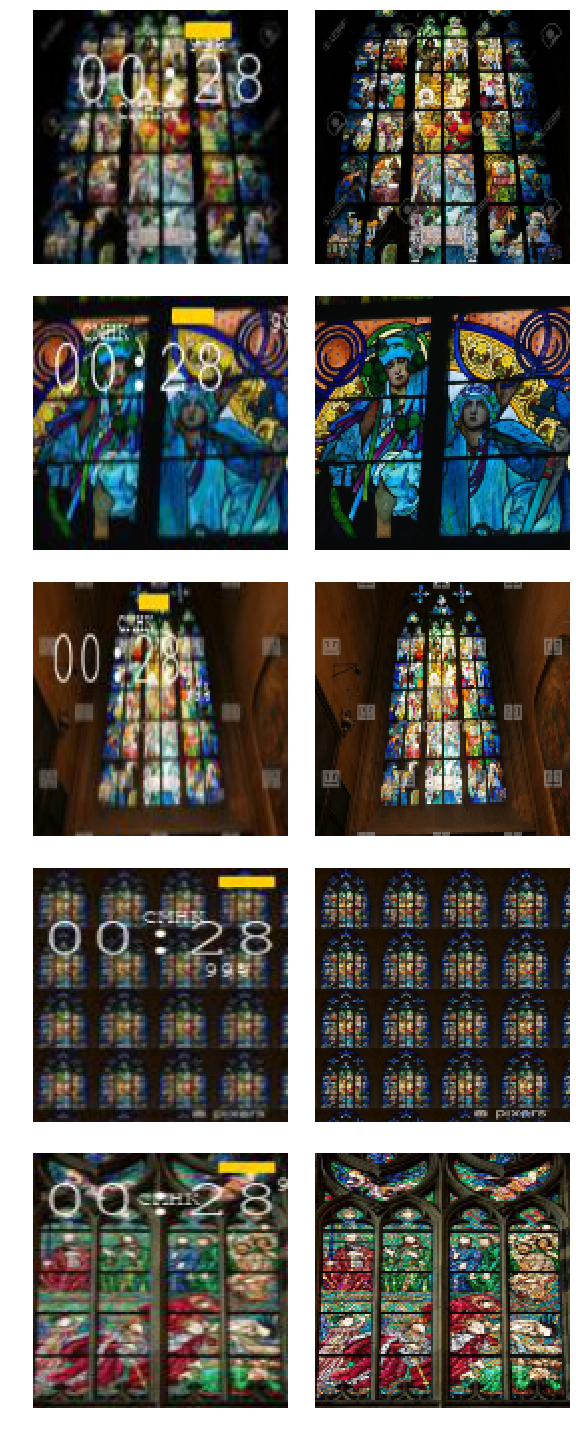

In [10]:
data_gen.show_batch()

In [11]:
# a matrix that contains every dot product of flattened activations, basically a correlation
#the Gram matrix then is this kind of map — the diagonal is perhaps the most interesting. 
#The diagonal is which channels are the most active and then the off diagonal is which channels tend to appear together. 
#And overall, if two pictures have the same style, 
#then we are expecting that some layer of activations, they will have similar Gram matrices

# dot product would be high when grid cells that have texture also have diagonal
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [12]:
base_loss = F.l1_loss

In [13]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [14]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [15]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [16]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [17]:
wd = 1e-3
learn = unet_learner(data_gen, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-03


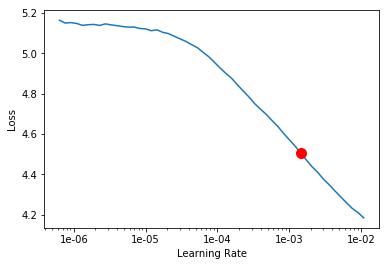

In [22]:
learn.recorder.plot(suggestion=True)

In [21]:
lr = 1e-3

def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

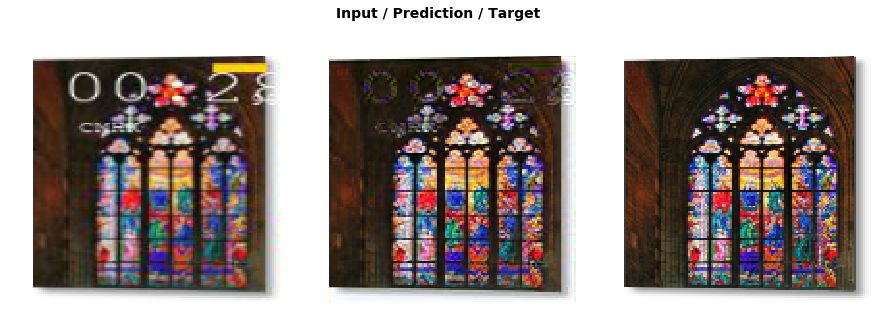

In [24]:
do_fit('1a', slice(lr*10))

In [25]:
learn.unfreeze()

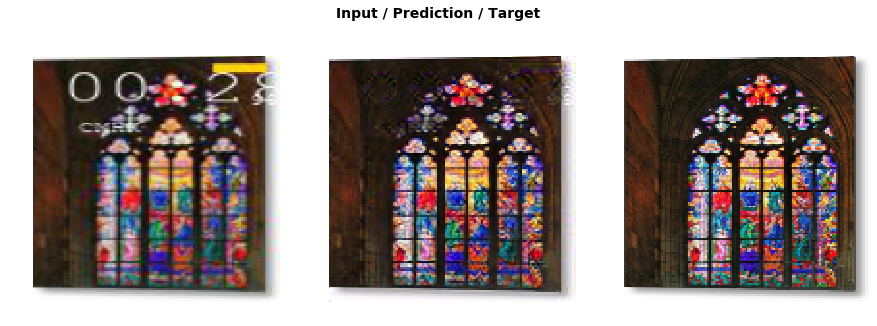

In [26]:
do_fit('1b', slice(1e-5,lr))

In [18]:
del data_gen 

In [25]:
data = get_data(6,size*2)

In [26]:
learn.data = data

learn.freeze()
gc.collect()

92

In [27]:
learn.load('1b');

/home/bf/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


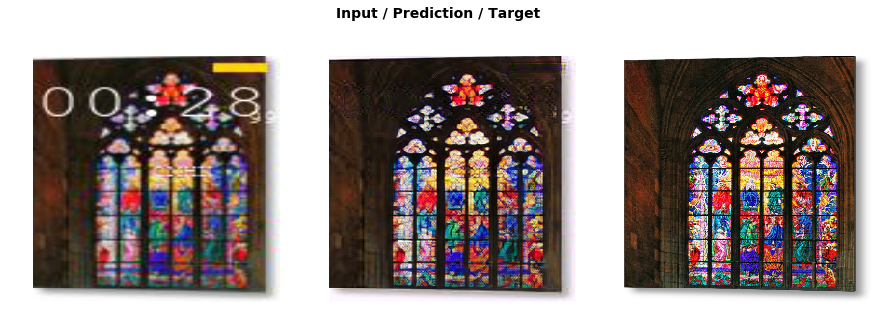

In [28]:
do_fit('2a')

In [29]:
learn.unfreeze()

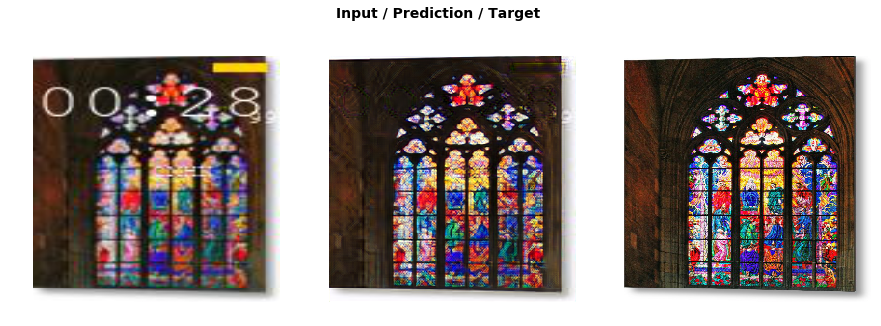

In [30]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

In [37]:
#learn = None
#gc.collect();

In [32]:
256/320*1024

819.2

In [33]:
256/320*1600

1280.0

In [34]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(820, 1024), have 5304MB of GPU RAM free


In [55]:
#learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)
#data = (src.label_from_func(lambda x: path_hr/x.name)
#       .transform(resize_method=ResizeMethod.SQUISH, tfm_y=True)
#       .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
#data.c = 3

In [56]:
#learn.load('2b');

In [57]:
#img = open_image('testing.jpg'); img.shape

In [58]:
#p,img_hr,b = learn.predict(img)

In [59]:
#show_image(img, figsize=(18,15), interpolation='nearest');

In [60]:
#show_image(img_hr, figsize=(18,15), interpolation='nearest');

In [21]:
size*3

384

In [20]:
del data_gen
gc.collect();

data = get_data(3,size*3)
learn.data = data
learn.load('2b');

/home/bf/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


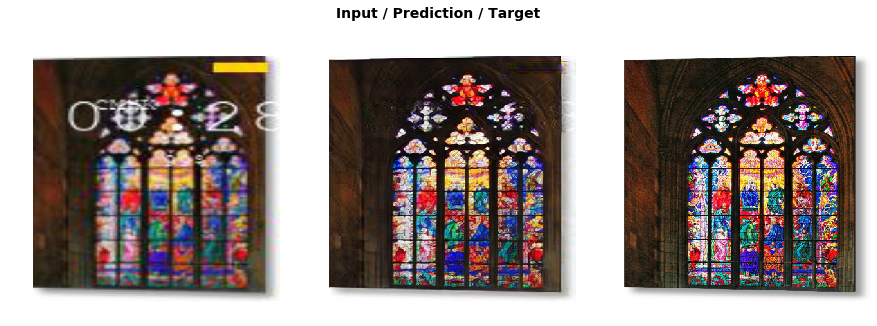

In [20]:
do_fit('3a')

In [21]:
learn.unfreeze()

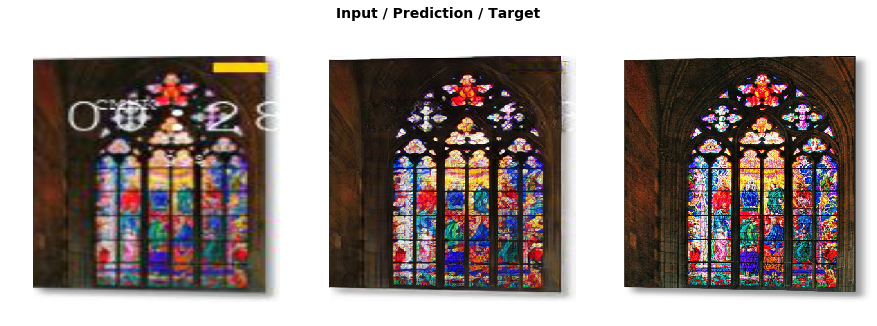

In [22]:
do_fit('3b', slice(1e-6,1e-4), pct_start=0.3)

In [21]:
learn.load('3b')

Learner(data=ImageDataBunch;

Train: LabelList (526 items)
x: ImageImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
Path: data/crappy;

Valid: LabelList (58 items)
x: ImageImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
y: ImageList
Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384),Image (3, 384, 384)
Path: data/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBloc

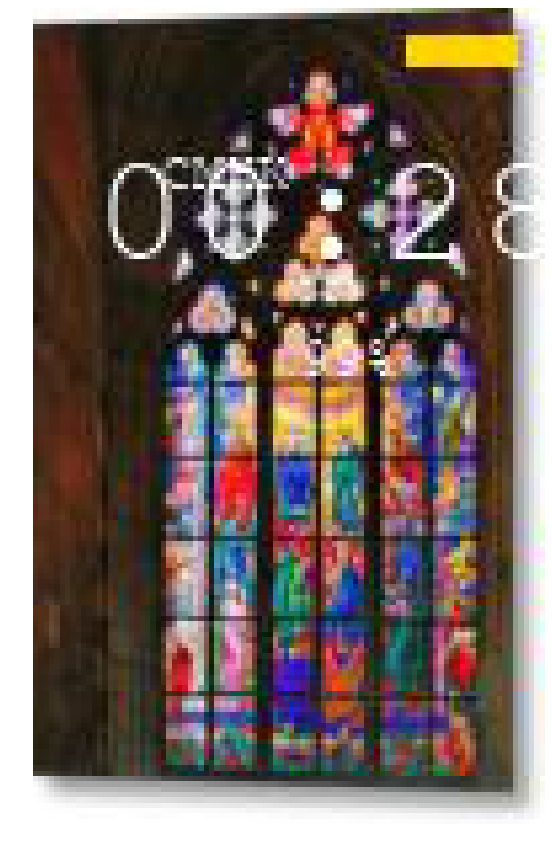

In [30]:
fn = data.train_ds.x.items[0]; fn
img = open_image(fn); img.shape
p,img_hr,b = learn.predict(img)
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


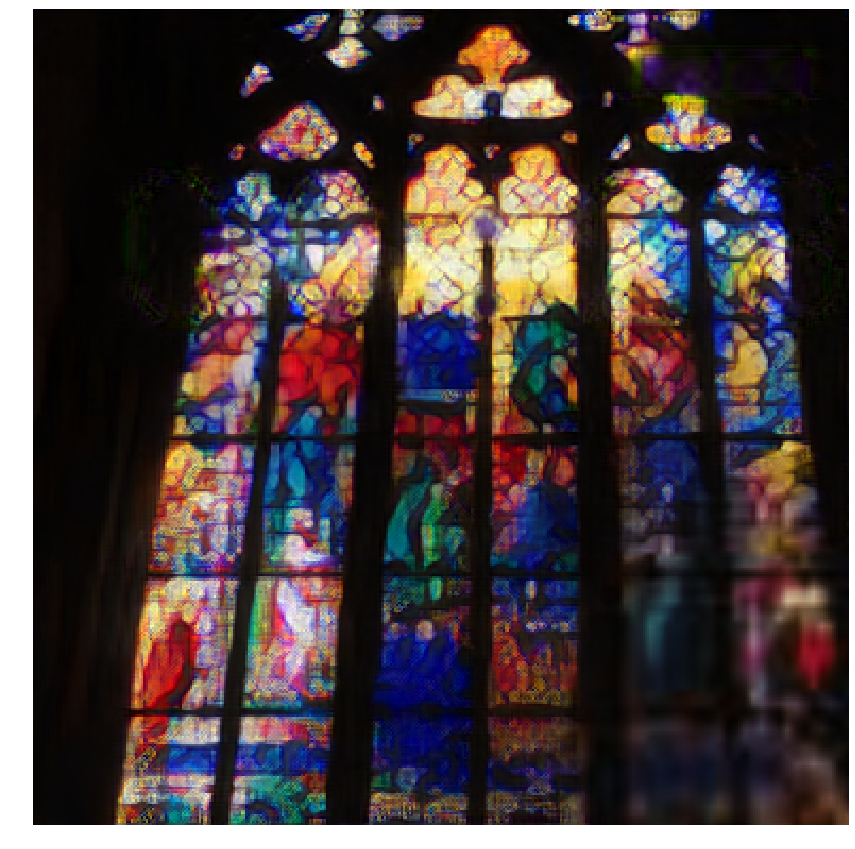

In [23]:
show_image(img_hr, figsize=(18,15), interpolation='nearest');

In [24]:
def get_test_data(bs):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(resize_method=ResizeMethod.SQUISH, size=(1000) ,tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [25]:
data = get_test_data(1)

In [26]:
learn.data = data

In [27]:
img = open_image('testing.jpg'); img.shape
p,img_hr,b = learn.predict(img)

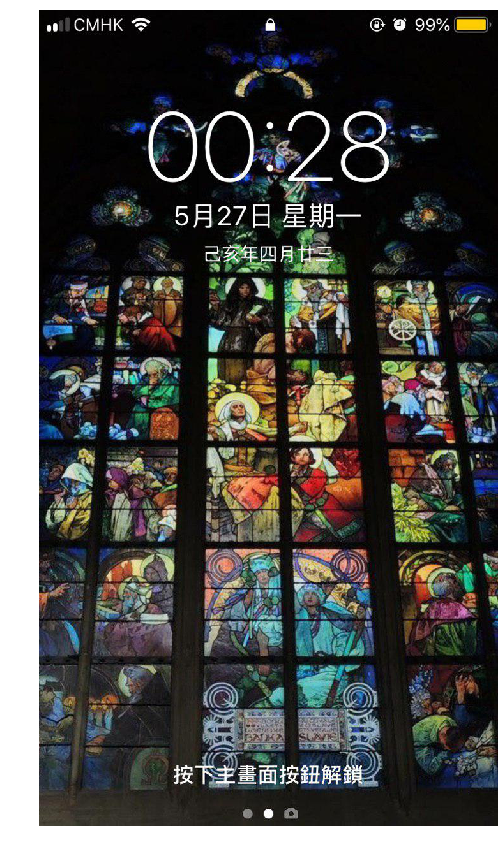

In [28]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


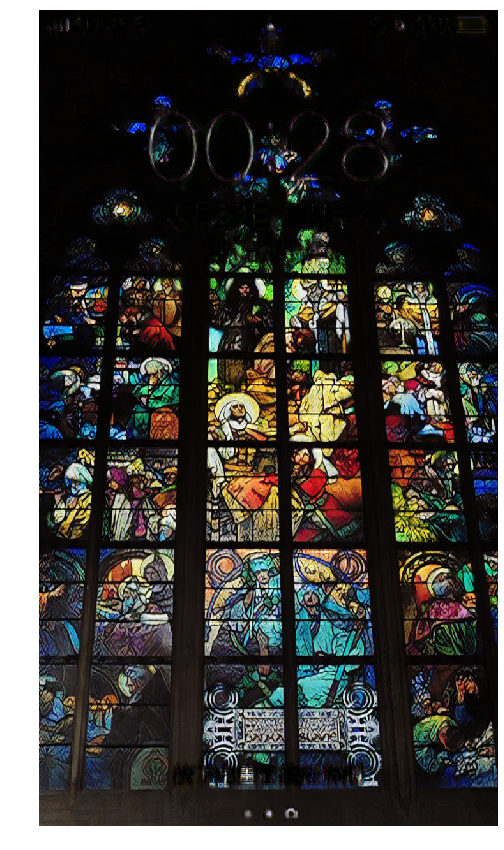

In [29]:
show_image(Image(img_hr).resize((3, 1280, 719)), figsize=(18,15), interpolation='nearest')